# Detecting Handwritten text in Documents

### Problem Statement
We wish to detect the handwritten text in the scanned/pdf document. It could be for number of reasons like 
- to identify if the document has been signed
- to process handwritten text in the document in a different way
- to mask the handwritten text


Take following document image for an example. We wish to detect the text highlighted in the red bounding boxes.
<img src="notebook_imgs/handwritten_sample.jpg">

### Training Dataset
We will use the annotated dataset available in the following github repo 
https://github.com/CatalystCode/Handwriting/tree/master/Data/labelledcontracttrainingdata/trainingjpg_output_99/

The dataset is part of the Microsoft blog available here 
https://devblogs.microsoft.com/cse/2018/05/07/handwriting-detection-and-recognition-in-scanned-documents-using-azure-ml-package-computer-vision-azure-cognitive-services-ocr/


Each image is annotated in Pascal VOC Annotation format using Microsoft Vott Annotation tool. The directory structure of the annotated dataset looks like this

data/Annotations_99  
data/JPEGImages_99

There are 99 annotated images in the dataset. The images are present in JPEGImages_99 folder and corresponding xml annotations are available under Annotations_99.

An XML annotation file looks like

```xml
<annotation verified="yes">
    <folder>Annotation</folder>
    <filename>07653e58-24d1-4b3f-9b4a-76057efe5c09-1</filename>
    <path>C:\data\JPEGImages\07653e58-24d1-4b3f-9b4a-76057efe5c09-1.jpg</path>
    <source>
        <database>Unknown</database>
    </source>
    <size>
        <width>1700</width>
        <height>2200</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>
    <object>
        <name>signature</name>
        <pose>Unspecified</pose>
        <bndbox>
            <xmin>192</xmin>
            <ymin>1188</ymin>
            <xmax>738</xmax>
            <ymax>1320</ymax>
         </bndbox>
    </object>
    ...
    ```
    
In Pascal VOC annotation, there is a seperate annotation file for each image. The data we are interested in the xml file is
  * image filename - 07653e58-24d1-4b3f-9b4a-76057efe5c09-1
  * object attribute for each annotation in the image
    * category/class of the marked annotation
    * bounding box coordinates of top left and right bottom position

### About Detectron2 Framework

We will use pytorch detectron2 framework because it is simple and easy to extend. There are simple Training, Visualization, and Prediction modules available in the detectron2 which handles most of the stuff and we can use it as is, or if required, we can extend the functionality.

Simple steps to train a vision model in Detectron2
  
  1. Convert dataset in the [detectron2 format](https://detectron2.readthedocs.io/tutorials/datasets.html#standard-dataset-dicts)
  2. [Register the dataset](https://detectron2.readthedocs.io/tutorials/datasets.html#register-a-dataset) and metadata information like class labels
  3. Update the config with registered dataset (DATASETS.{TRAIN,TEST}), model weight (MODEL.WEIGHT), learning rate, Number of output classes (MODEL.ROI_HEADS.NUM_CLASSES), and other training and test parameters
  4. Train the model using [DefaultTrainer](https://github.com/facebookresearch/detectron2/blob/master/detectron2/engine/defaults.py) class
  
 
#### Dataset Preparation(step 1 & 2)
Detectron2 expects the dataset as list[dict] in the following format. So for training with detectron2 we will have to convert our dataset in the following format.

```json
[{'file_name': 'datasets/JPEGImages/1.jpg',
  'image_id': '1',
  'height': 3300,
  'width': 2550,
  'annotations': [{'category_id': 1,
    'bbox': [1050.1000264270613,
     457.33333333333337,
     1406.9139799154334,
     587.7450980392157],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>},
   {'category_id': 1,
    'bbox': [1529.9097515856238,
     473.5098039215687,
     1617.167679704017,
     555.3921568627452],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>}]}]
```

Detectron registers this list of dict as torch dataset and uses the default dataloader and datasampler for training. We can register the list[dict] with detectron2 using following code

``` python
def get_dicts():
  ...
  return list[dict] in the above format

from detectron2.data import DatasetCatalog
DatasetCatalog.register("my_dataset", get_dicts)
```

And to register the metadata information related to dataset like category mapping to id's, the type of dataset, we have to set the keyvalue pair using

```python
MetadataCatalog.get("my_dataset").thing_classes = ["person", "dog"]
```

#### Choosing a Model and Initializing Configuration (step 3)

Detectron2 has lot of pretrained model available in the [model zoo](https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md). For handwritten text detection, we will choose Faster RCNN with FPN backbone. 

We have to initialize the parameters and weights for model we want to train. 

``` python
cfg = get_cfg()
cfg.merge_from_file('<pretrained model config'>)
cfg.MODEL.WEIGHTS = '<path to pretrained model weight>

#custom config for training
cfg.DATASETS.TRAIN = ("<registered training dataset name>",)
cfg.SOLVER.MAX_ITER = '<number of training iterations>'
cfg.MODEL.ROI_HEADS.NUM_CLASSES = '<number of classes>'
```

All the model configs are available in cfg object. If we want to replicate the training later, we can save the cfg object and load it back to resume training.

#### Model Training (step 4)
We will use the DefaultTrainer for now. There are simple modules available which only accept the minimal parameters and make assumptions about lot of things.  

The DefaultTrainer Module 
  * builds the model
  * builds the optimizer
  * builds the dataloader
  * loads the model weights, and
  * register common hooks
  
```python
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()
```


Now, we can train our Instance Detection model using Detectron2. We will try FasterRCNN-FPN-50 Model and see how it performs

## 1. Prepare & Visualize the Dataset

To visualize the labeled dataset in detectron2, we need to convert the xml annotations in the detectron2 dataset format as explained above.

We will use the custom function register_pascal_voc() which will convert the dataset into detectron2 format and register it with DatasetCatalog. It expects the directory structure like

    Annotations  
    JPEGImages  
    train.txt

train.txt and test.txt have a filename(without extension) per row

#### Visualizer Class
To draw the annotations on the images, we will use the Detectron2 Visualizer class which takes the image in rgb format, the metadata which has ordered label names and the scale parameter. 

    Visualizer.draw_instance_predictions() function to visualize prediction results
    Visualizer.draw_dataset_dict() function to draw the annotated dataset


In [16]:
%matplotlib inline

In [1]:
import dataset_utils

#register dataset
split ='train'
train_dataset_name = 'signature_dataset_'+split
dataset_utils.register_pascal_voc(train_dataset_name, dirname='datasets', split=split, CLASS_NAMES=["signature","others"])

In [2]:
def visualize_dataset(datasetname, n_samples):
    from detectron2.data import DatasetCatalog, MetadataCatalog
    import random
    import cv2
    from detectron2.utils.visualizer import Visualizer
    from matplotlib.pyplot import figure
    from matplotlib import pyplot as plt

    dataset_dicts = DatasetCatalog.get(train_dataset_name)
    metadata = MetadataCatalog.get(train_dataset_name)

    for d in random.sample(dataset_dicts,n_samples):
        print(d['file_name'])
        img = cv2.imread(d["file_name"])
        visualizer = Visualizer(img[:, :, ::-1],
        metadata=metadata, scale=0.5)
        vis = visualizer.draw_dataset_dict(d)
        figure(num=None, figsize=(15, 15), dpi=100, facecolor='w', edgecolor='k')
        plt.imshow(vis.get_image()[:, :, ::-1])
        plt.show()

datasets/JPEGImages/888d0b50-2f77-4230-8e89-cbf63e8109f2-1.jpg


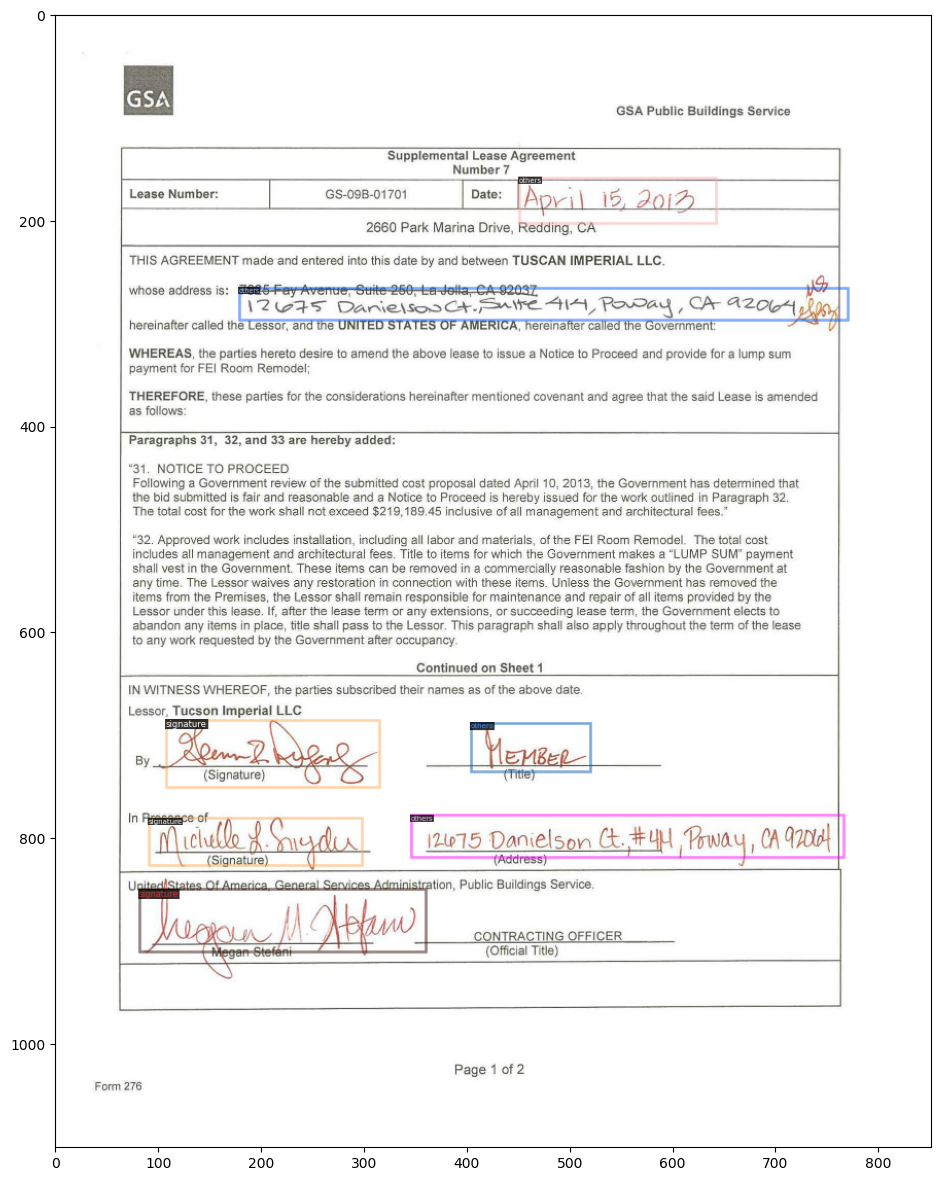

datasets/JPEGImages/7baf7eec-24ab-46be-830f-893bf6cdd24a-4.jpg


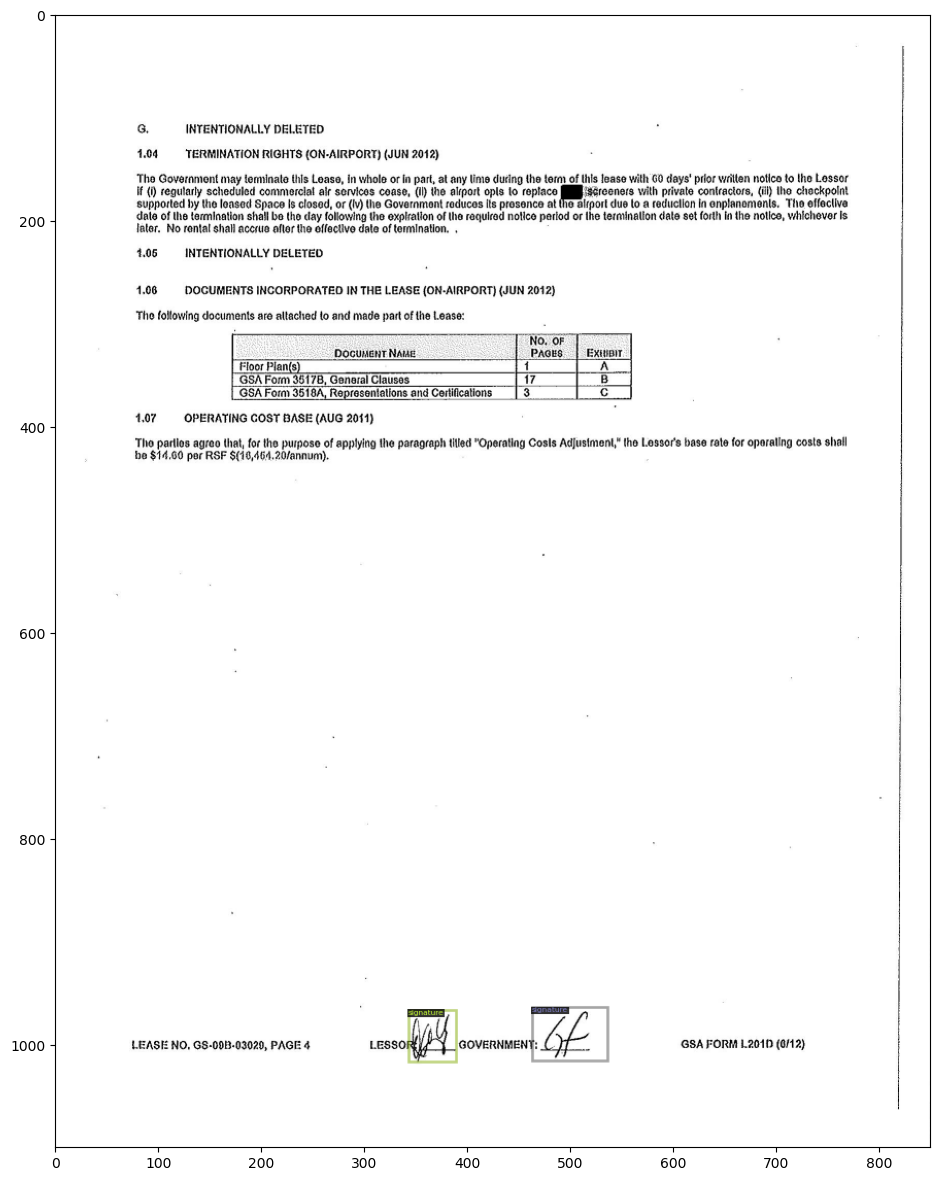

In [3]:
visualize_dataset('signature_dataset_train',2)

## 2. Model Training


In [99]:
from detectron2.engine import default_argument_parser
from detectron2.engine import DefaultTrainer
import config

parser = default_argument_parser() 
args = parser.parse_args("--config-file sign_config/sign_faster_rcnn_R_50_FPN_3x.yaml OUTPUT_DIR sign_model ".split())

We have copied the config file for Faster RCNN R50 FPN from the [model zoo](https://github.com/facebookresearch/detectron2/blob/master/configs/COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml) as sign_faster_rcnn_R_50_FPN_3x.yaml and updated the configuration parameters. We have set the MODEL.ROI_HEADS(classes) to 2, Max Number of iterations to 4000, and training dataset name to the one we registered earlier.

config.setup_cfg function will load the configuration from the --config-file path, and will update the configration with other parameters passed as arguments

Here, we have passed the OUTPUT_DIR parameter to update the cfg.OUTPUT_DIR parameter value

In [ ]:
cfg = config.setup_cfg(args)

Now that we have all the configurations, we can start training the model. As I explained earlier, DefaultTrainer will build the model(without weights), optimizer, learning rate scheduler and then load weights from the checkpoint file specified in the cfg.MODEL.WEIGHTS parameter.

In [ ]:
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

## 3. Model Prediction

In the model training, we have saved the updated config file in the output directory. It has all the parameters except model weight. We pass the model weight path as paramter to load the trained model weight.

The DefaultPredictor does some image translation and takes only single image for prediction. But we can easily modify the DefaultPredictor class to accept batch of input images for prediction

In [ ]:
from detectron2.engine import default_argument_parser
from detectron2.engine import DefaultPredictor
import config

parser = default_argument_parser()
args = parser.parse_args("--config-file sign_model/config.yaml MODEL.WEIGHTS sign_model/model_final.pth".split())
cfg = config.setup_cfg(args)

predictor = DefaultPredictor(cfg)

0.20569086074829102
test_images/image_11.jpg


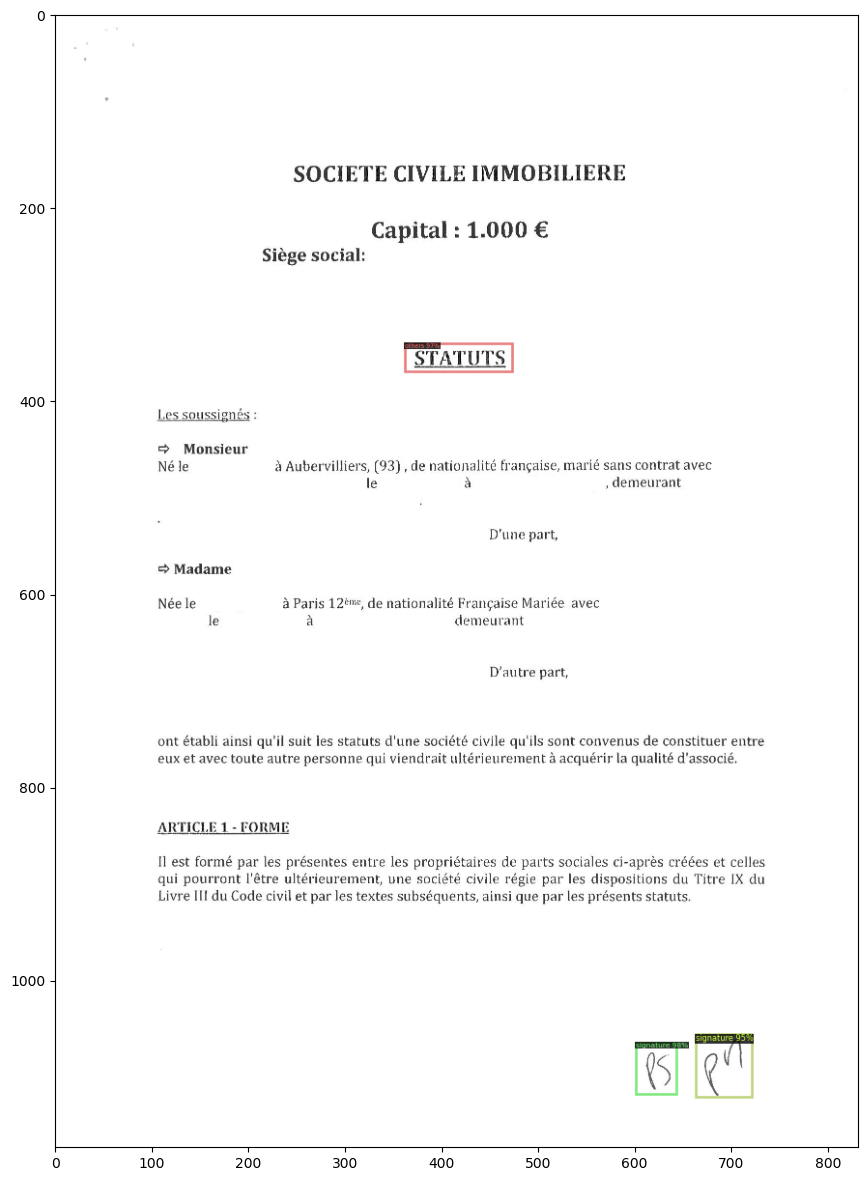

0.18455862998962402
test_images/0d0eddfc-731b-44de-b84d-d265afc7d996-1.jpg


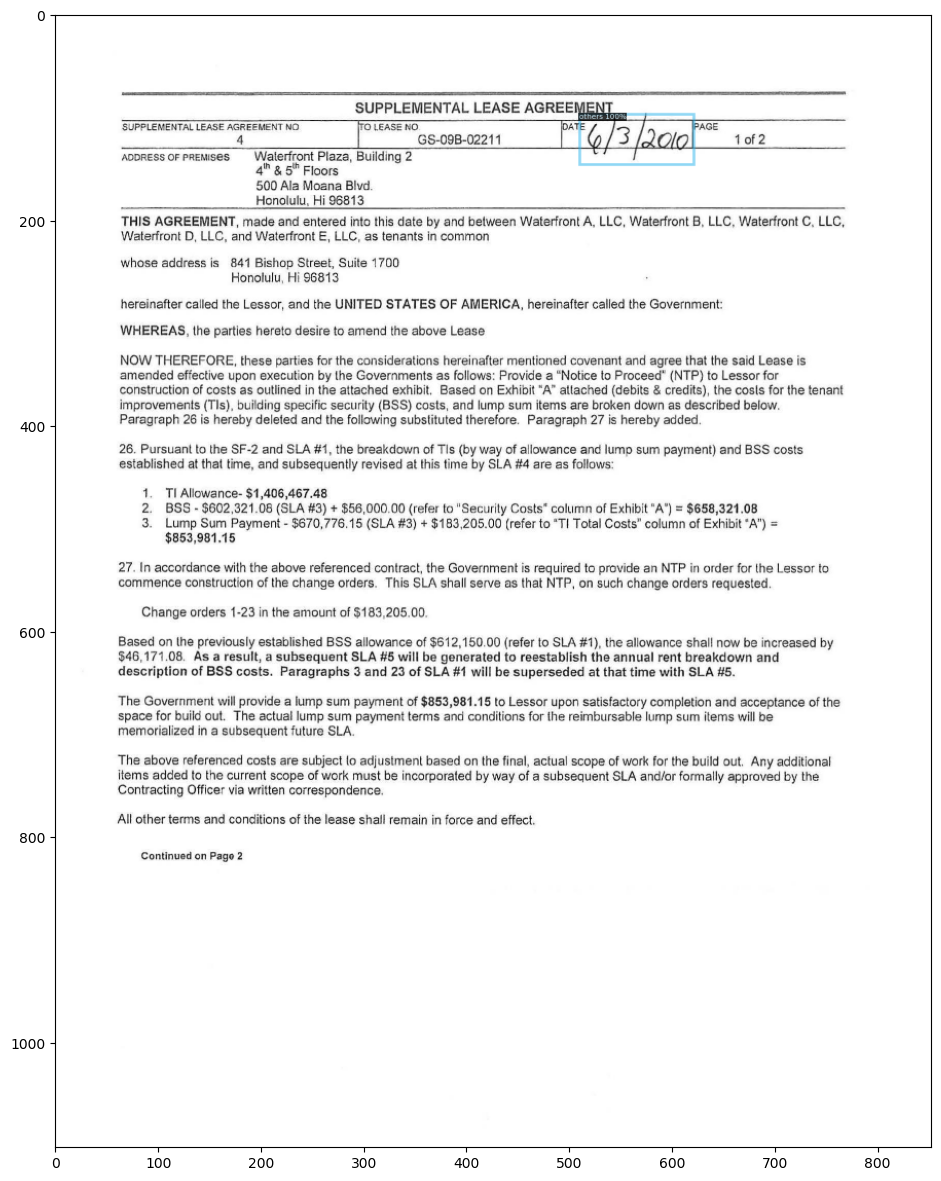

0.17723822593688965
test_images/07653e58-24d1-4b3f-9b4a-76057efe5c09-6.jpg


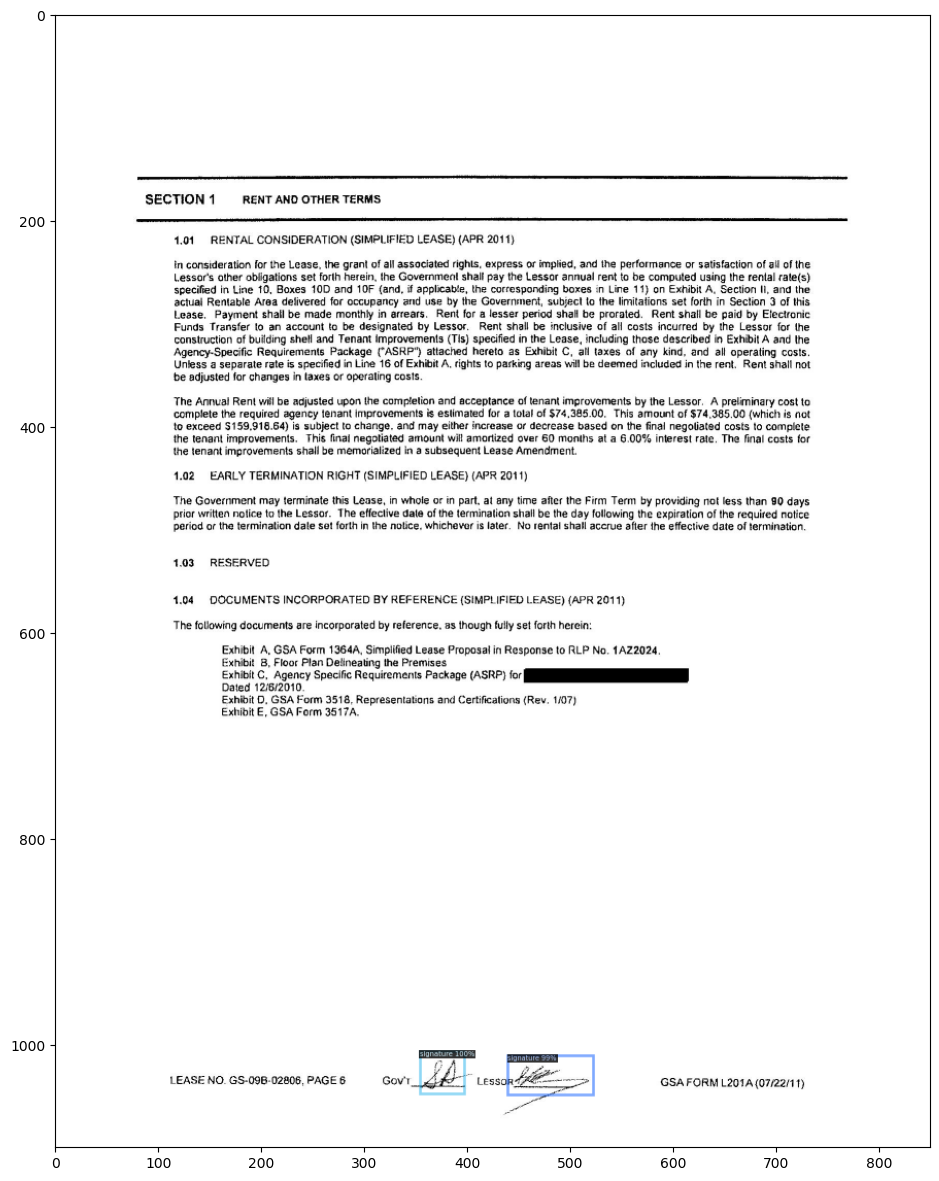

0.18737411499023438
test_images/0d0eddfc-731b-44de-b84d-d265afc7d996-2.jpg


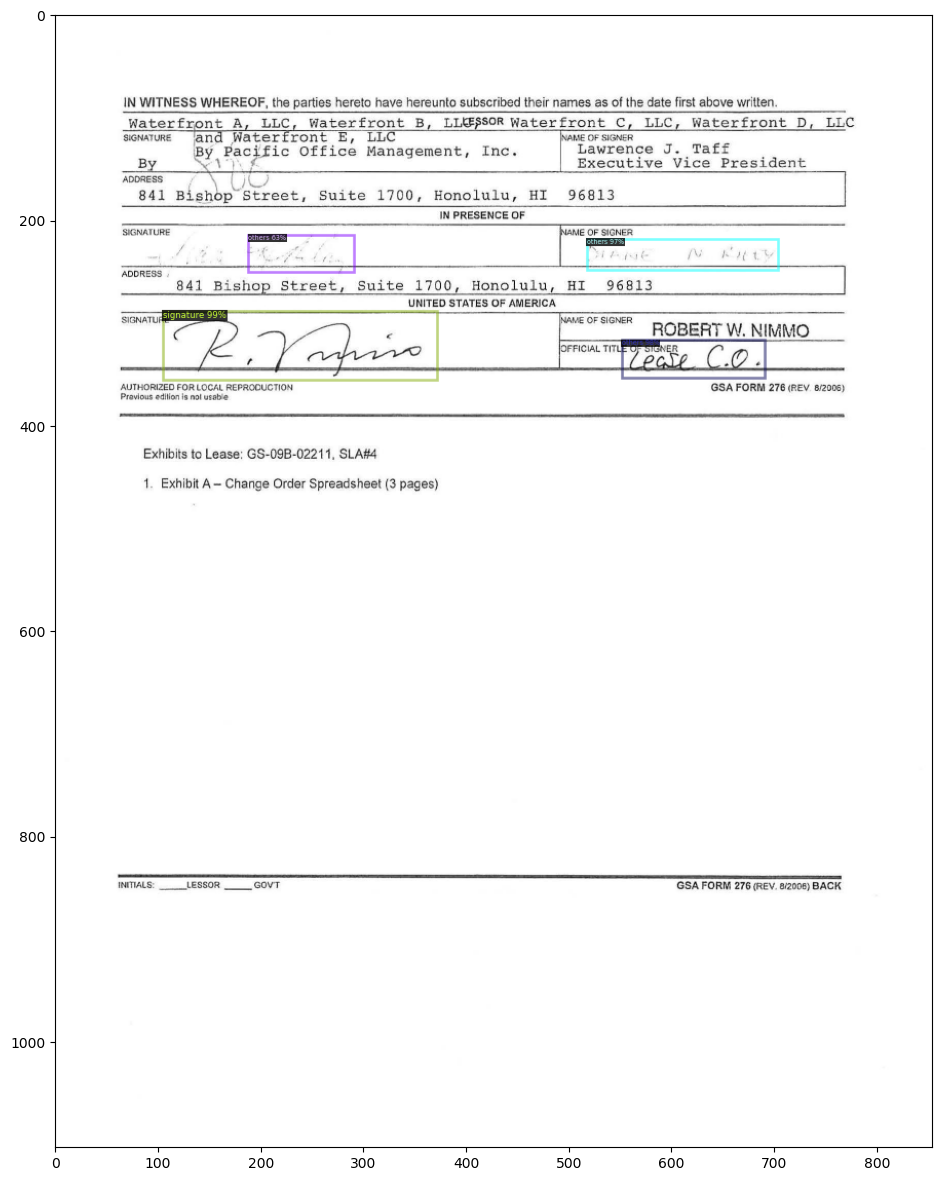

0.18267059326171875
test_images/image_10.jpg


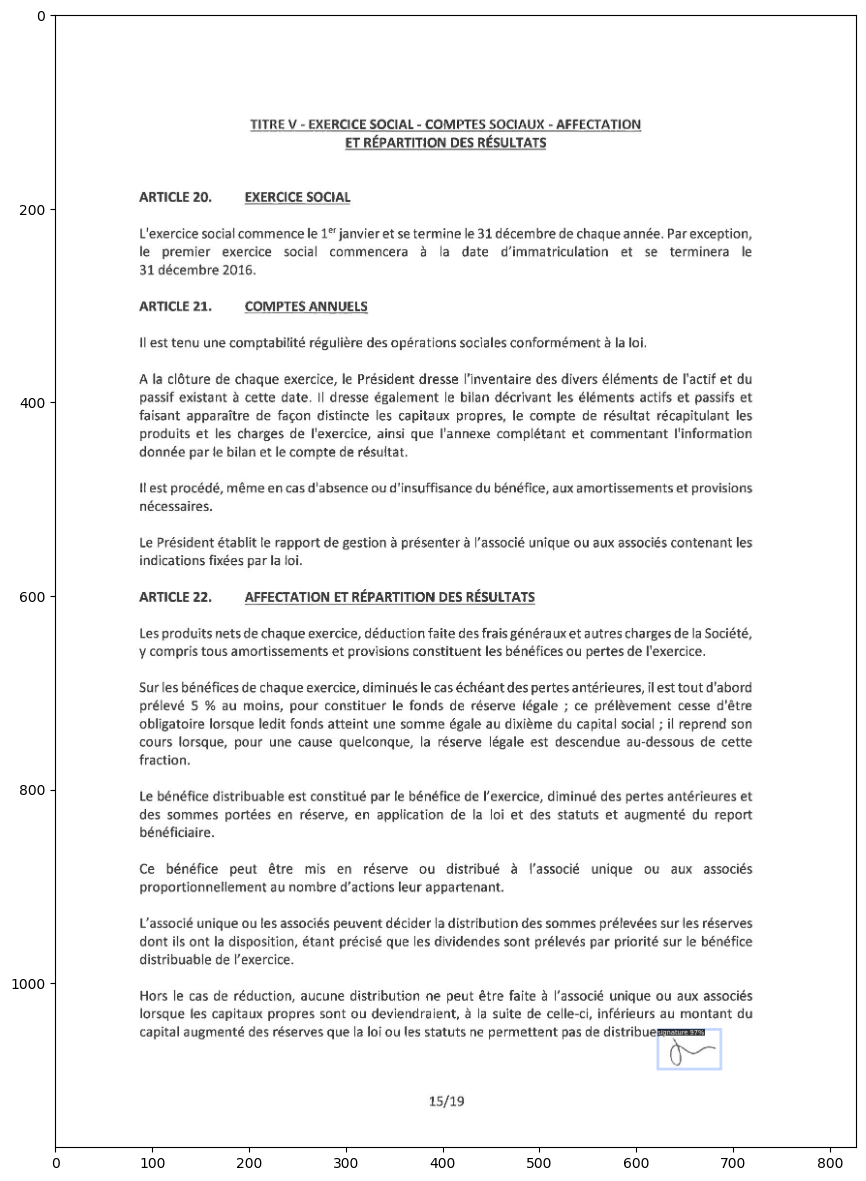

In [6]:
import glob 
import time
import os 

from matplotlib.pyplot import figure
from matplotlib import pyplot as plt
import cv2

from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

files = glob.glob("test_images/*.jpg")
sample_size = 5
for file,_ in zip(files,range(sample_size)):
    im = cv2.imread(file)
    MetadataCatalog.get("signature_dataset_train").thing_classes = ["signature","others"]
    start_time = time.time()
    outputs = predictor(im)
    print(time.time()- start_time)
    
    v = Visualizer(im[:, :, ::-1], metadata=MetadataCatalog.get("signature_dataset_train"), scale=0.5)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    print(file)
    figure(num=None, figsize=(15, 15), dpi=100, facecolor='w', edgecolor='k')
    plt.imshow(v.get_image()[:, :, ::-1])
    plt.show()

### Training on a Custom Dataset

Let us say we have got some more annotated dataset which is not in PASCAL VOC xml format. To train the above model model, we have write a custom function get_dicts() which returns data in detectron2 format.

To improve the accuracy of handwriting detection, I found one more dataset which is of annotated french documents. The annotations are in json format for each image. The dataset is available in the following github repo
https://github.com/hyperlex/Signature-detection-Practical-guide/tree/master/data/dataset. Download and save it in french_dataset directory

In [3]:
import json 
import glob
import os
import cv2
from detectron2.structures import BoxMode
def get_french_dicts(annot_dir):
    json_files = glob.glob(os.path.join(annot_dir,'*.json'))
    
    dataset_dicts = []
    
    for f in json_files:
        record={}
        img_ann = json.load(open(f))
        
        filename = img_ann['asset']['name']
        height, width = cv2.imread(os.path.join(annot_dir,'..',filename)).shape[:2]
        
        record["file_name"] = os.path.join(annot_dir,'..',filename)
        record["image_id"] = img_ann['asset']['id']
        record["height"] = height
        record["width"] = width
      
        annos = img_ann["regions"]
        objs =[]
        for ann in annos:
            px = ann['boundingBox']['left']
            py = ann['boundingBox']['top']
            px1 = ann['boundingBox']['left'] + ann['boundingBox']['width']
            py1 = ann['boundingBox']['top'] + ann['boundingBox']['height']
            
            obj = {
                "bbox": [px, py, px1, py1],
                "bbox_mode": BoxMode.XYXY_ABS,
                "category_id": {'signature':0,'paraphe':1,'date':1}[ann['tags'][0]],
                "iscrowd": 0
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

In [1]:
from detectron2.utils.visualizer import Visualizer
from detectron2.data import DatasetCatalog, MetadataCatalog
import dataset_utils 

def get_img_dicts():
    ann1 = dataset_utils.load_voc_instances(dirname = 'datasets', split = 'train', CLASS_NAMES=["signature","others"])
    ann2 = get_french_dicts('french_dataset/per_img_labels')
    return ann1 + ann2

dataset_name = 'signature_dataset_train'
DatasetCatalog.register(dataset_name, lambda: get_img_dicts())
MetadataCatalog.get(dataset_name).set(thing_classes=["signature","others"])

Metadata(name='signature_dataset_train', thing_classes=['signature', 'others'])

datasets/JPEGImages/89646792-ff91-4508-8373-62ddb08e6171-1.jpg


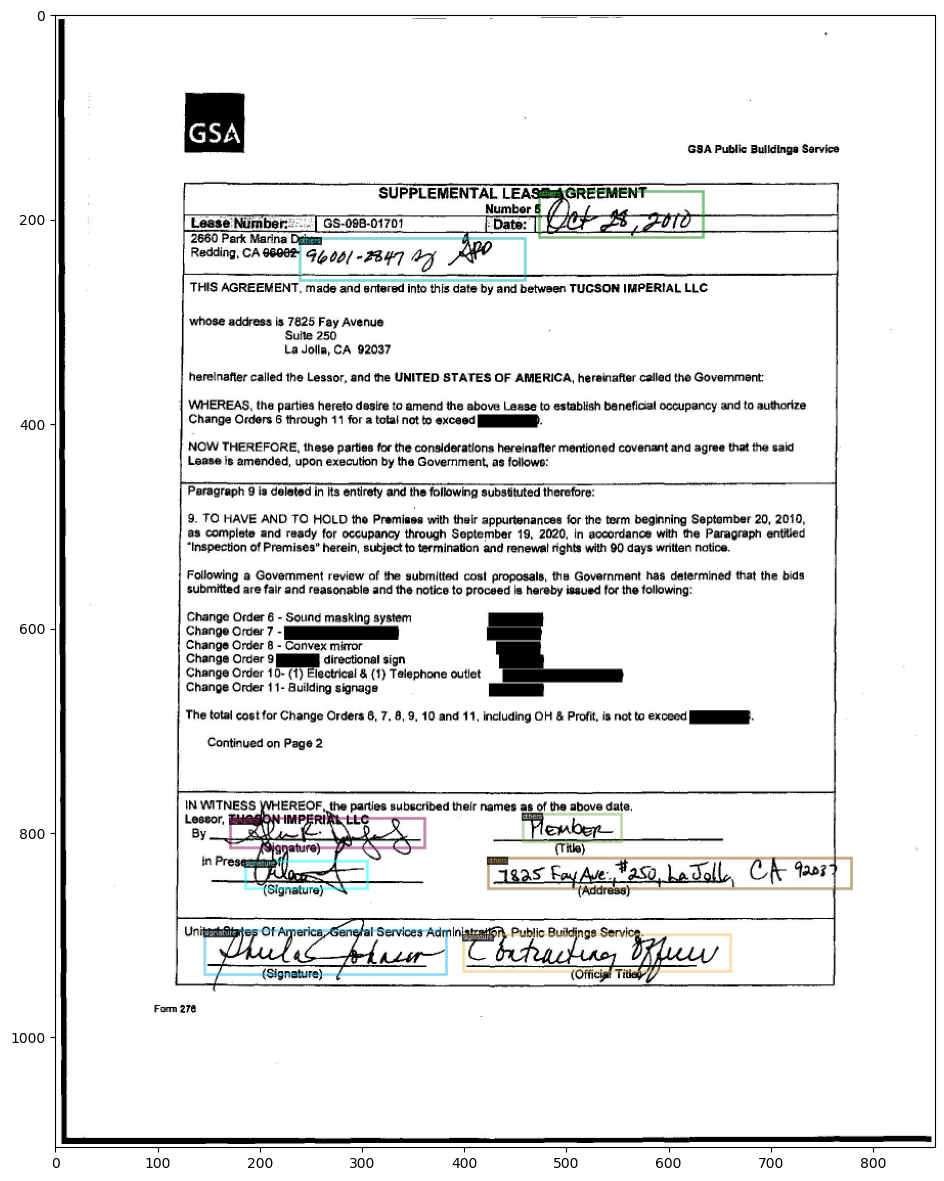

datasets/JPEGImages/4c85bb9b-1d8d-45b0-8f4a-664d77ee4b83-3.jpg


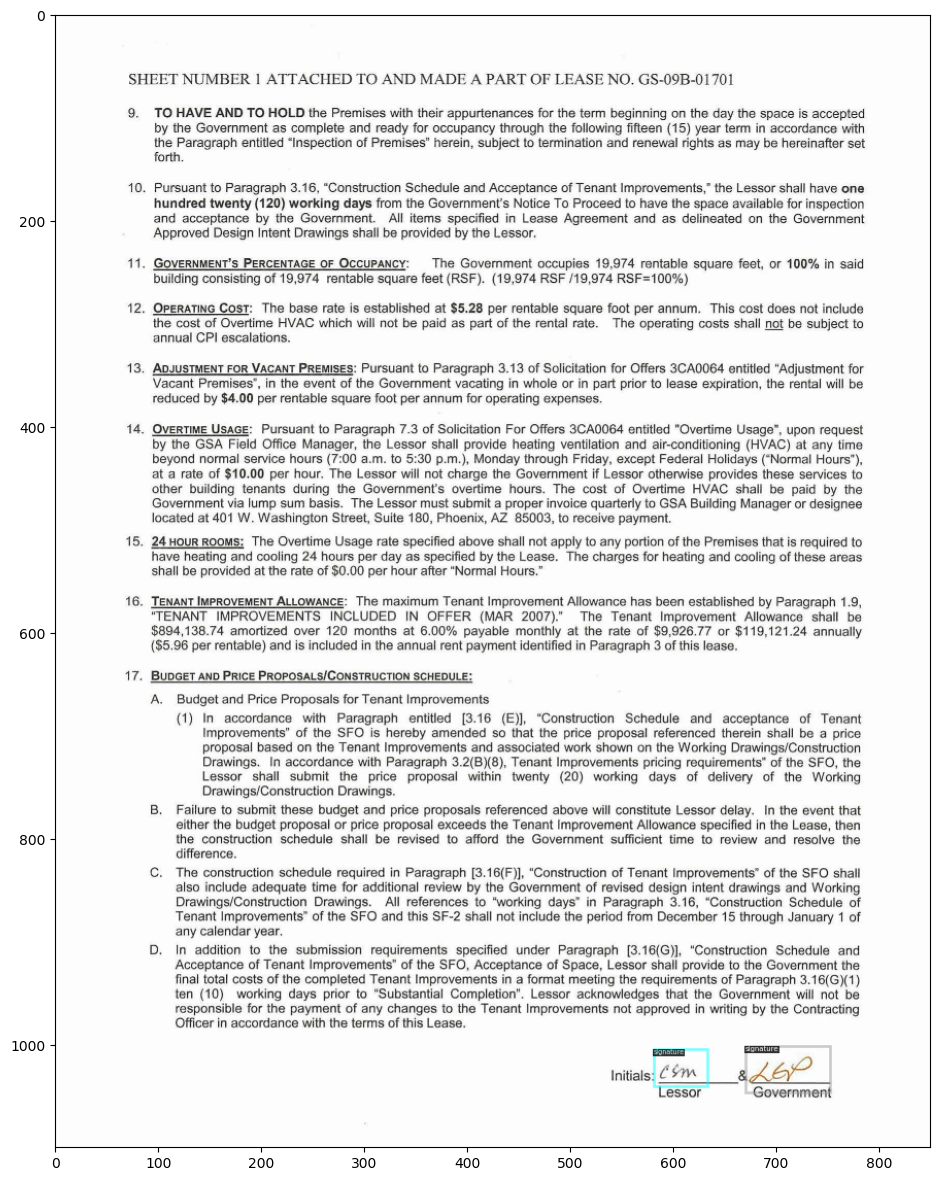

In [7]:
dataset_utils.visualize_dataset('signature_dataset_train', n_samples=2)

We can run the remaining steps as we did before for training the model and prediction